In [ ]:
import torch
import datasets
import evaluate
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
import pandas as pd

# Preparation for training

## Utils

In [ ]:
class PreProcessor:
  def __init__(self,label2id, max_length):

    self.label2id = label2id
    self.max_length = max_length

  def __call__(self, examples):
    return tokenizer(examples["document_extracted"], truncation=True, max_length=self.max_length) | {"label": [self.label2id[el] for el in examples["document_topic"]]}

In [ ]:
def compute_metrics(eval_pred):
  accuracy = evaluate.load("accuracy")
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)
  return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
def get_repliqa_info(repliqa_ds):
  topics = np.unique(repliqa_ds["document_topic"])
  id2label = {i:v for i,v in enumerate(sorted(topics))}
  label2id = {v:k for k,v in id2label.items()}

  return id2label, label2id

In [ ]:
def clean_repliqa(repliqa_ds):
  filtered_repliqa_ds = repliqa_ds.filter(lambda example: not example["long_answer"]=="NA")
  pd_repliqa_ds = pd.DataFrame(filtered_repliqa_ds)
  deduplicated_repliqa_ds = datasets.Dataset.from_pandas(pd_repliqa_ds.drop_duplicates(subset=["document_id"]))
  return deduplicated_repliqa_ds


## Getting data and model

In [ ]:
MODEL_NAME = "allenai/longformer-base-4096"

In [ ]:
repliqa_dataset = datasets.load_dataset("ServiceNow/repliqa", split="repliqa_0")
id2label, label2id = get_repliqa_info(repliqa_dataset)
cleaned_repliqa_dataset = clean_repliqa(repliqa_dataset)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=len(id2label), id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True
)

In [ ]:
tokenized_repliqa_dataset = cleaned_repliqa_dataset.map(PreProcessor(label2id, model.config.max_position_embeddings-2), batched=True)

In [ ]:
split_repliqa_dataset = tokenized_repliqa_dataset.shuffle(seed=42).train_test_split(test_size=0.10)

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Training

In [ ]:
training_args = TrainingArguments(
    output_dir="repliqa_topic_classifier",
    learning_rate=3e-5,
    warmup_steps=100,
    adam_beta1=0.9,
    adam_beta2=0.95,
    max_grad_norm=1.0,
    label_smoothing_factor=0.01,
    per_device_train_batch_size=3,
    per_device_eval_batch_size=3,
    num_train_epochs=10,
    weight_decay=0.001,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=split_repliqa_dataset["train"],
    eval_dataset=split_repliqa_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

# Visualizing results

In [ ]:
model_device = next(trainer.model.parameters()).device
test_model = trainer.model
test_model.eval()

predictions, labels = [], []
for example in trainer.eval_dataset:
  with torch.no_grad():
    inputs = tokenizer(
        [example["document_extracted"]],
        truncation=True, max_length=test_model.config.max_position_embeddings-2,
        return_tensors="pt").to(model_device)
    pred = trainer.model(**inputs).logits.argmax(-1).squeeze().item()
  predictions.append(pred)
  labels.append(example["label"])

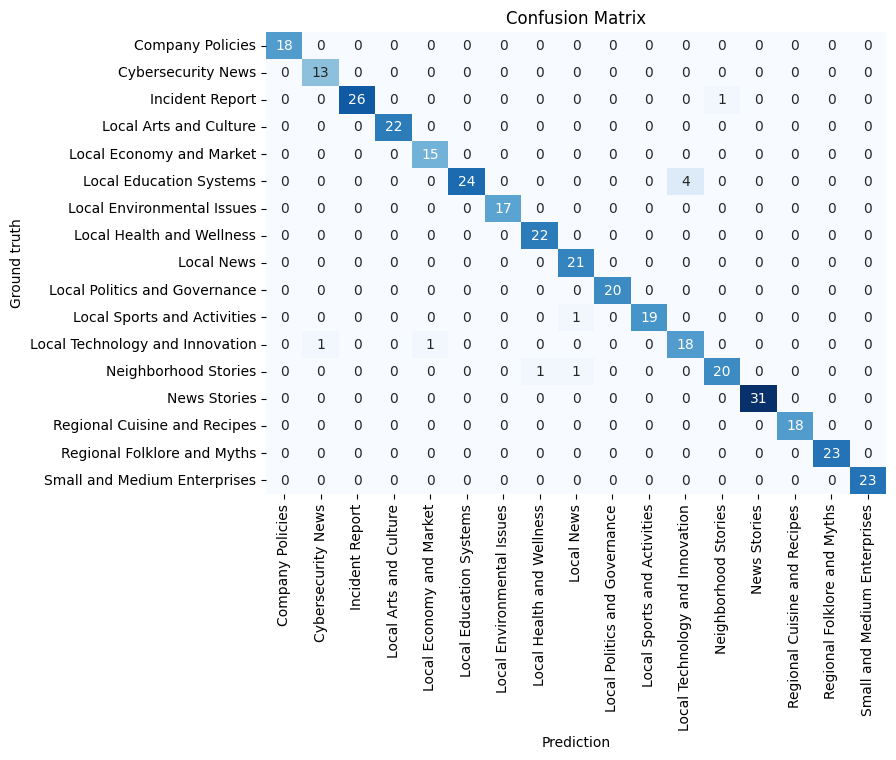

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(labels, predictions)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[f'{id2label[i]}' for i in range(conf_matrix.shape[0])],
            yticklabels=[f'{id2label[i]}' for i in range(conf_matrix.shape[0])])

plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.title('Confusion Matrix')
plt.show()
